In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/Example'
! ls

/content/gdrive/MyDrive/Example
10_Fine_tuning_VGG16.ipynb     6_Cifar10_VGG16.ipynb
1_MLP_Fashion_MNIST.ipynb      7_Custom_dataset_VGG16.ipynb
2_MLP_Cifar10.ipynb	       8_Chest_Xray.ipynb
3_Classification_Models.ipynb  9_Feature_extractor_VGG16.ipynb
4_LeNet.ipynb		       chest_xray.zip
5_VGG16.ipynb		       Dataset


In [3]:
# import the basic libraries
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Flatten, Reshape, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D, Concatenate, Lambda, add
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from glob import glob

**VGG16**

In [4]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/Example/Dataset/train'
valid_path = '/content/gdrive/MyDrive/Example/Dataset/valid'
test_path = '/content/gdrive/MyDrive/Example/Dataset/test'

In [5]:
# add preprocessing layer to the front of VGG16
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
# don't train existing weights
for layer in vgg16.layers:
  layer.trainable = False

In [7]:
# useful for getting number of classes
folders = glob('/content/gdrive/MyDrive/Example/Dataset/train/*')

In [8]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [9]:
#x = Dense(128, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 32 using train_datagen generator
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            shuffle = False,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 240 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [14]:
# fit the model
vgg16 = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=20)

Epoch 1/20
8/8 [==============================] - 113s 14s/step - loss: 1.2709 - accuracy: 0.5292 - val_loss: 0.5837 - val_accuracy: 0.7000
Epoch 2/20
8/8 [==============================] - 4s 468ms/step - loss: 0.5493 - accuracy: 0.7458 - val_loss: 0.3306 - val_accuracy: 0.8333
Epoch 3/20
8/8 [==============================] - 4s 420ms/step - loss: 0.3599 - accuracy: 0.8500 - val_loss: 0.2414 - val_accuracy: 0.9000
Epoch 4/20
8/8 [==============================] - 4s 430ms/step - loss: 0.2069 - accuracy: 0.9167 - val_loss: 0.1400 - val_accuracy: 0.9667
Epoch 5/20
8/8 [==============================] - 3s 419ms/step - loss: 0.1463 - accuracy: 0.9625 - val_loss: 0.1237 - val_accuracy: 0.9667
Epoch 6/20
8/8 [==============================] - 3s 420ms/step - loss: 0.1146 - accuracy: 0.9792 - val_loss: 0.1142 - val_accuracy: 0.9667
Epoch 7/20
8/8 [==============================] - 3s 406ms/step - loss: 0.1096 - accuracy: 0.9708 - val_loss: 0.1168 - val_accuracy: 0.9667
Epoch 8/20
8/8 [====

In [15]:
#model.save('vgg16.h5')

In [16]:
# testing
score = model.evaluate(test_set, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Test loss: 0.0685
Test accuracy: 0.9667


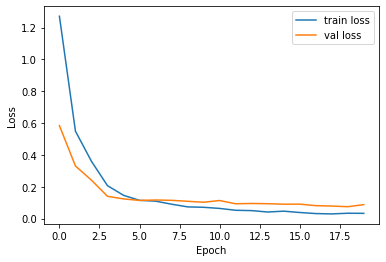

In [17]:
# loss
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(vgg16.history['loss'], label='train loss')
plt.plot(vgg16.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#fig.savefig('loss_vgg16', dpi=3000)

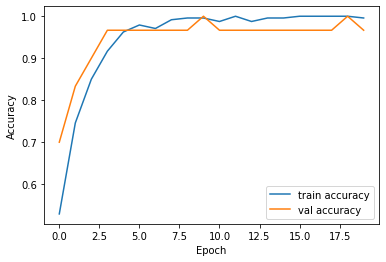

In [18]:
# accuracy
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(vgg16.history['accuracy'], label='train accuracy')
plt.plot(vgg16.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#fig.savefig('accuracy_vgg16', dpi=3000)

**Confusion matrix:**

In [19]:
#importing confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
Y_pred = model.predict(x=test_set, steps=len(test_set), verbose=0)

<Figure size 432x288 with 0 Axes>

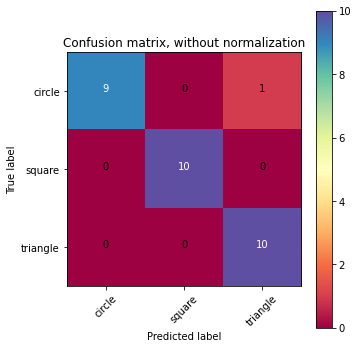

<Figure size 432x288 with 0 Axes>

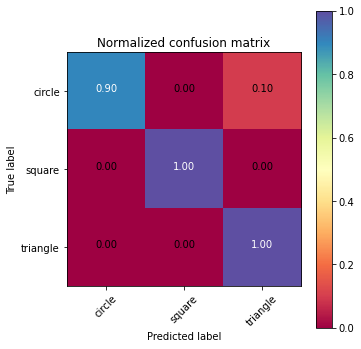

In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true = test_set.classes, y_pred = np.argmax(Y_pred, axis = -1))
class_names = ['circle', 'square', 'triangle']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [22]:
#Confution Matrix and Classification Report
y_true = test_set.classes
Y_pred = model.predict(test_set, len(test_set))
y_pred = np.argmax(Y_pred, axis = 1)
print('Confusion Matrix\n')
print(confusion_matrix(y_true, y_pred))
print('\nClassification Report\n')
target_names = ['circle', 'square', 'triangle']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

1/1 [==============================] - 0s 91ms/step
Confusion Matrix

[[ 9  0  1]
 [ 0 10  0]
 [ 0  0 10]]

Classification Report

              precision    recall  f1-score   support

      circle       1.00      0.90      0.95        10
      square       1.00      1.00      1.00        10
    triangle       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

